# Bayesian GWB Searches
*Author: William G. Lamb*

Last updated: July 9th 2024

Material in this notebook is based on [lectures by Stephen R. Taylor](https://github.com/astrolamb/astr_8070_s21/) and citations within, and a [lecture by Jeff Hazboun](https://github.com/VIPER-Research-Group/gw-school-2022-materials/blob/master/Week_2/Day_2/sampling_the_enterprise_likelihood.ipynb) at the 2022 VIPER GW Summer School.

In this notebook, you'll learn how to run Bayesian searches for a GWB in PTA data with different Bayesian techniques, some methods we use to optimise the searches, and how we post-process our analyses.

## Contents
- [Introduction](#introduction)
- [Technique 1: MCMC](#technique-1-markov-chain-monte-carlo-mcmc)
- [Technique 2: Savage-Dickey](#technique-2-savage-dickey-density-ratio-sddr)
- [Technique 3: 'HyperModel'](#technique-3-product-space-sampling-aka-hypermodel)
- [Technique 4: Nested Sampling](#technique-4-nested-sampling)
- [Other techniques](#other-techniques)
- [Exercises](#exercises)

In [1]:
# Let's import the modules that we'll require in this tutorial
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'  # retina quality

import os, pickle
import numpy as np
from matplotlib import pyplot as plt
import PTMCMCSampler.PTMCMCSampler as ptmcmc
from enterprise.signals import (gp_priors, parameter, gp_signals, signal_base,
                                white_signals)
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions.model_orfs import hd_orf
from enterprise_extensions.sampler import setup_sampler
from enterprise_extensions.hypermodel import HyperModel
from emcee.autocorr import integrated_time
import corner.corner as corner

[AS807ELVDM:14744] shmem: mmap: an error occurred while determining whether or not /var/folders/n5/tlyhfd1j5s7gm9fxj02byc0c0000gn/T//ompi.AS807ELVDM.501/jf.0/2113667072/sm_segment.AS807ELVDM.501.7dfc0000.0 could be created.


You'll also need to install a package called `la_forge` in the terminal

```bash
pip install la-forge
```

In [2]:
import la_forge.core as co
import la_forge.diagnostics as dg

(Did you get a warning about `astropy`? That's ok, we don't need it!)

## Introduction

Bayesian analysis is powerful. We allow the data to inform our modeling fitting and to check if our theoretical understanding supports the data we have collected. However, Bayesian analysis can also be difficult and slow, depending on the quantity of data that we're attempting to fit against, the complexity of our models, and the type of Bayesian analysis that we use.

Let's begin by setting up our PTA model as we learnt in the previous session. The data set that we'll be using was simulated by Nima Laal and it contains 45 pulsars. The intrinsic red noise that was injected into each pulsar's data is a 5-frequency powerlaw with the maximum likelihood amplitude and spectral index for the pulsar from the NANOGrav 12.5yr data set. The injected white noise is EFAC=1. The injected GWB is a 5-frequency powerlaw with a characteristic strain amplitude of $A=6\times10^{-15}$ at a reference frequency of $1\text{yr}^{-1}$, and a spectral index of $\gamma=13/3$.

We're going to create two fixed-$\gamma$ PTA models: a 'common uncorrelated red noise' CURN model (i.e. the GWB has no inter-pulsar correlations), and a HD (Hellings & Downs-correlated) model. To make our analyses faster, let's randomly select 

In [3]:
# open simulated PTA data with pickle
data_loc = './data/sim_ng_psrs.pkl'

with open(data_loc, 'rb') as f:
    psrs = pickle.load(f)

Tspan = get_tspan(psrs)  # compute timespan of data

In [4]:
print(f'Number of pulsars: {len(psrs)}')
print(f'Timespan of data: {Tspan/365.24/86400:.2f} yrs')

Number of pulsars: 45
Timespan of data: 20.12 yrs


Text(0, 0.5, 'Residuals [s]')

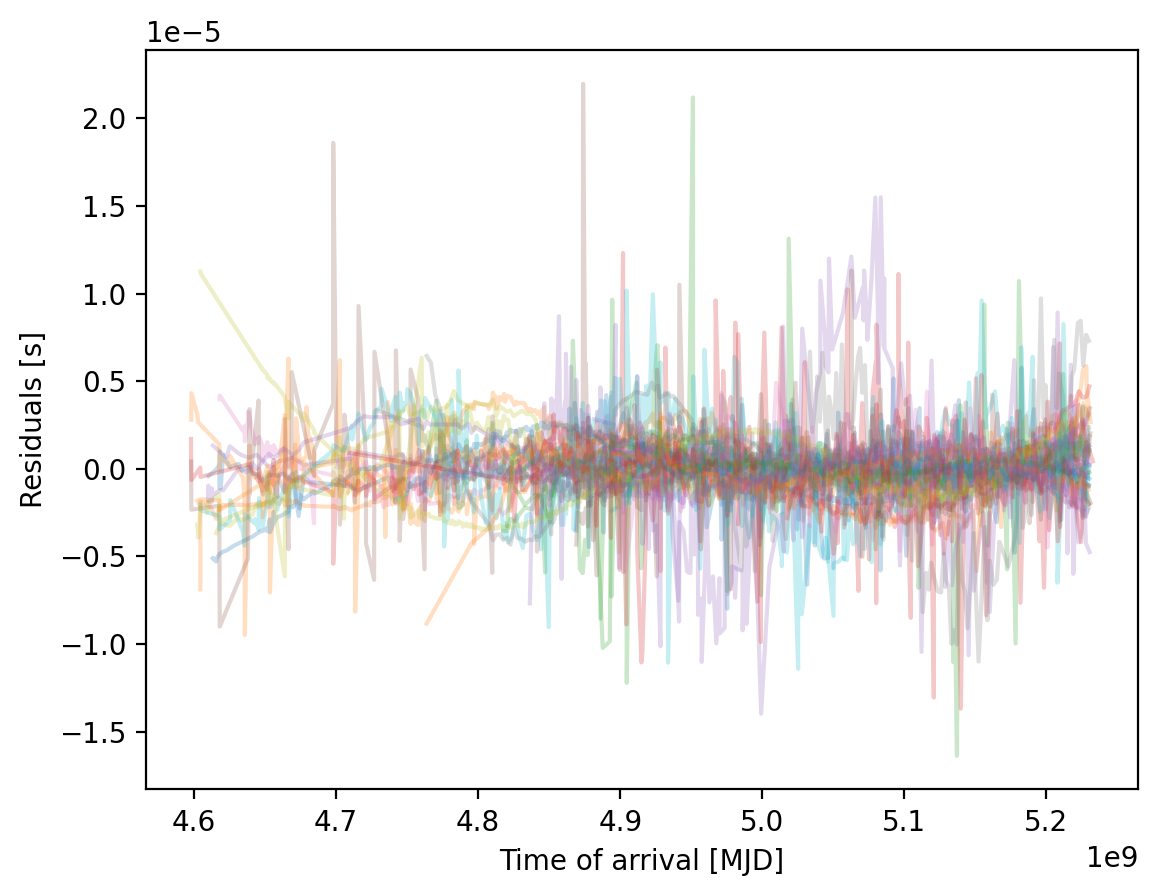

In [5]:
# let's take a look at the residuals in the data
for p in psrs:
    plt.plot(p.toas, p.residuals, alpha=0.25)

plt.xlabel('Time of arrival [MJD]')
plt.ylabel('Residuals [s]')

For speed, we're just going to analyse 10 pulsars out of the 45

In [6]:
rng = np.random.default_rng(seed=45)
#selected_psrs = psrs
#selected_psrs = rng.choice(psrs, 10, replace=False)

In [7]:
# setting up our model
# timing model
tm = gp_signals.MarginalizingTimingModel()

# white noise model
efac = parameter.Constant(1.0)
wn = white_signals.MeasurementNoise(efac=efac)

# intrinsic red noise
log10_A_rn = parameter.Uniform(-18, -12)
gamma_rn = parameter.Uniform(0, 7)
rn_psd = gp_priors.powerlaw(log10_A=log10_A_rn, gamma=gamma_rn)
rn = gp_signals.FourierBasisGP(rn_psd, Tspan=Tspan, components=5)

# gwb
log10_A_gw = parameter.Uniform(-18, -12)('log10_A_gw')
#gamma_gw = parameter.Uniform(0, 7)('gamma_gw')
gamma_gw = parameter.Constant(13/3)('gamma_gw')
gw_psd = gp_priors.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
curn = gp_signals.FourierBasisGP(gw_psd, Tspan=Tspan,
                                 components=5, name='gw')  # CURN
hd = gp_signals.FourierBasisCommonGP(gw_psd, hd_orf(), Tspan=Tspan,
                                     components=5, name='gw_hd')  # HD

# full model
model_curn = tm + wn + rn + curn
model_hd = tm + wn + rn + hd

# set up PTA
pta_curn = signal_base.PTA([model_curn(p) for p in selected_psrs])
pta_hd = signal_base.PTA([model_hd(p) for p in selected_psrs])

---
Here's a quick reminder of Bayes Theorem:

$$\text{Probability of model hyperparameters }\vec{\theta}\text{ given data }\vec{d}\text{ and model }\mathcal{M}: $$
$$= \frac{\text{Probability of data }\vec{d}\text{ given model }\mathcal{M} \text{ and hyperparameters }\vec{\theta} \times \text{Prior on model hyperparameters }\vec{\theta}}{\text{Evidence}} $$

$$ p(\vec{d}|\mathcal{M}, \vec{\theta}) = \frac{\mathcal{L}(\vec{\theta}|\vec{d}, \mathcal{M})p(\vec{\theta}|\mathcal{M})}{\mathcal{Z}}$$

---
## Technique 1: Markov Chain Monte Carlo (MCMC)

Uses: parameter estimation, can be further used for model selection

We are attempting to evaluate the hyperparameters $\vec{\theta}$ of $\mathcal{M}$ given the data $\vec{d}$. We can do this using *Markov Chain Monte Carlo* (MCMC), which you learnt about yesterday.

What is nice about MCMC is that we're only fitting the one model, so we don't need to evaluate the Bayesian evidence $\mathcal{Z} = \int \mathcal{L}(\vec{\theta}|\vec{d}, \mathcal{M})p(\vec{\theta}|\mathcal{M}) \mathrm{d}\vec{\theta}$, which normalises the likelihood and prior given the model we're fitting. This integral is computationally difficult to compute, but it's a constant, so we can ignore it for an MCMC fit on a single model. (We'll come back to evaluating $\mathcal{Z}$ later - it will become important later!)

Let's try out some MCMC! There are many different MCMC samplers that we could use - `emcee`, `eryn`, and `pymc` are popular. However, we use `PTMCMCSampler` in NANOGrav, and we'll explain why later. Here's the documentation for PTMCMCSampler:

In [8]:
ptmcmc.PTSampler?

Init signature:
ptmcmc.PTSampler(
    ndim,
    logl,
    logp,
    cov,
    groups=None,
    loglargs=[],
    loglkwargs={},
    logpargs=[],
    logpkwargs={},
    logl_grad=None,
    logp_grad=None,
    comm=<mpi4py.MPI.Intracomm object at 0x115c8d7a0>,
    outDir='./chains',
    verbose=True,
    resume=False,
    seed=None,
)
Docstring:     
Parallel Tempering Markov Chain Monte-Carlo (PTMCMC) sampler.
This implementation uses an adaptive jump proposal scheme
by default using both standard and single component Adaptive
Metropolis (AM) and Differential Evolution (DE) jumps.

This implementation also makes use of MPI (mpi4py) to run
the parallel chains.

Along with the AM and DE jumps, the user can add custom
jump proposals with the ``addProposalToCycle`` fuction.

@param ndim: number of dimensions in problem
@param logl: log-likelihood function
@param logp: log prior function (must be normalized for evidence evaluation)
@param cov: Initial covariance matrix of model parameters for 

To run a basic MCMC, we just need to define just a few parameters: the number of parameters `ndim`, the likelihood function `logl`, the prior function `logp`, and a covariance matrix `cov` between the parameters (we'll explain why later). To save the output from the MCMC, we also need to create an output directory `outDir`.

In [9]:
ndim = len(pta_curn.params)  # number of parameters
logl = pta_curn.get_lnlikelihood  # log likelihood of the pta
logp = pta_curn.get_lnprior  # log prior of the pta
cov = np.identity(ndim) * 0.01  # cov matrix - this is the typical matrix used
outDir = './results/my_first_pta_mcmc/'
os.makedirs(outDir, exist_ok=True)  # create output directory

In [10]:
# initialise the sampler!
sampler = ptmcmc.PTSampler(ndim=ndim, logl=logl, logp=logp,
                           cov=cov, outDir=outDir)

The MCMC doesn't start automatically! We need to define a point from where it will start. We can define that point manually, or we can randomly select a point within our model priors.

In [11]:
# randomly select a initial point
x0 = np.array([p.sample() for p in pta_curn.params])
print(x0)

[  5.66471602 -14.83662637   5.94059124 -17.1200494    4.47709677
 -15.8209364    6.31695596 -13.40087062   1.83153413 -16.74464405
   6.70786667 -14.57078617   0.92970375 -12.13664133   2.13824762
 -15.66550094   5.06850179 -15.31975534   5.6562437  -12.56749403
 -16.04884806]


Finally, we need to tell the sampler how many samples it should collect `Niter`. Let's keep this simple and collect 1,000 samples.

**NOTE:** PTMCMCSampler 'thins' the resulting chain of samples by 10. This is to reduce the autocovariance between sample points (explained below). Hence, if we want to collect 1,000 samples, we need `Niter = 10_000`

In [12]:
sampler.sample(x0, 10_000)

Finished 0.00 percent in 0.005038 s Acceptance rate = 0

/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 100.00 percent in 32.508133 s Acceptance rate = 0.35186
Run Complete


Let's now investigate how well our MCMC went! We can use `la_forge` to load our chain and run some diagnostic tests.

We open our chain into a `la_forge.core.Core` module.

In [13]:
c0 = co.Core(chaindir=outDir, burn=0, params=pta_curn.param_names)  # we'll explain what `burn` means later

There are three methods we can use to look at our chains and see how well it fit to our data.
1. Check the traceplots
2. Gelman-Rubin metric
3. Autocorrelation length

Let's first look at the traceplots. We're looking for a chain which suggests that the sampler has explored the parameter space really well. This is important because the likelihood function is a complicated, multi-dimensional surface, and we want to make sure that our sampler hasn't gotten itself stuff in a *local minima* (a point that is the minimum point relative to its neighbouring points, but not the global minimum for the overall likelihood). We use `la_forge.diagnostics.plot_chains`.

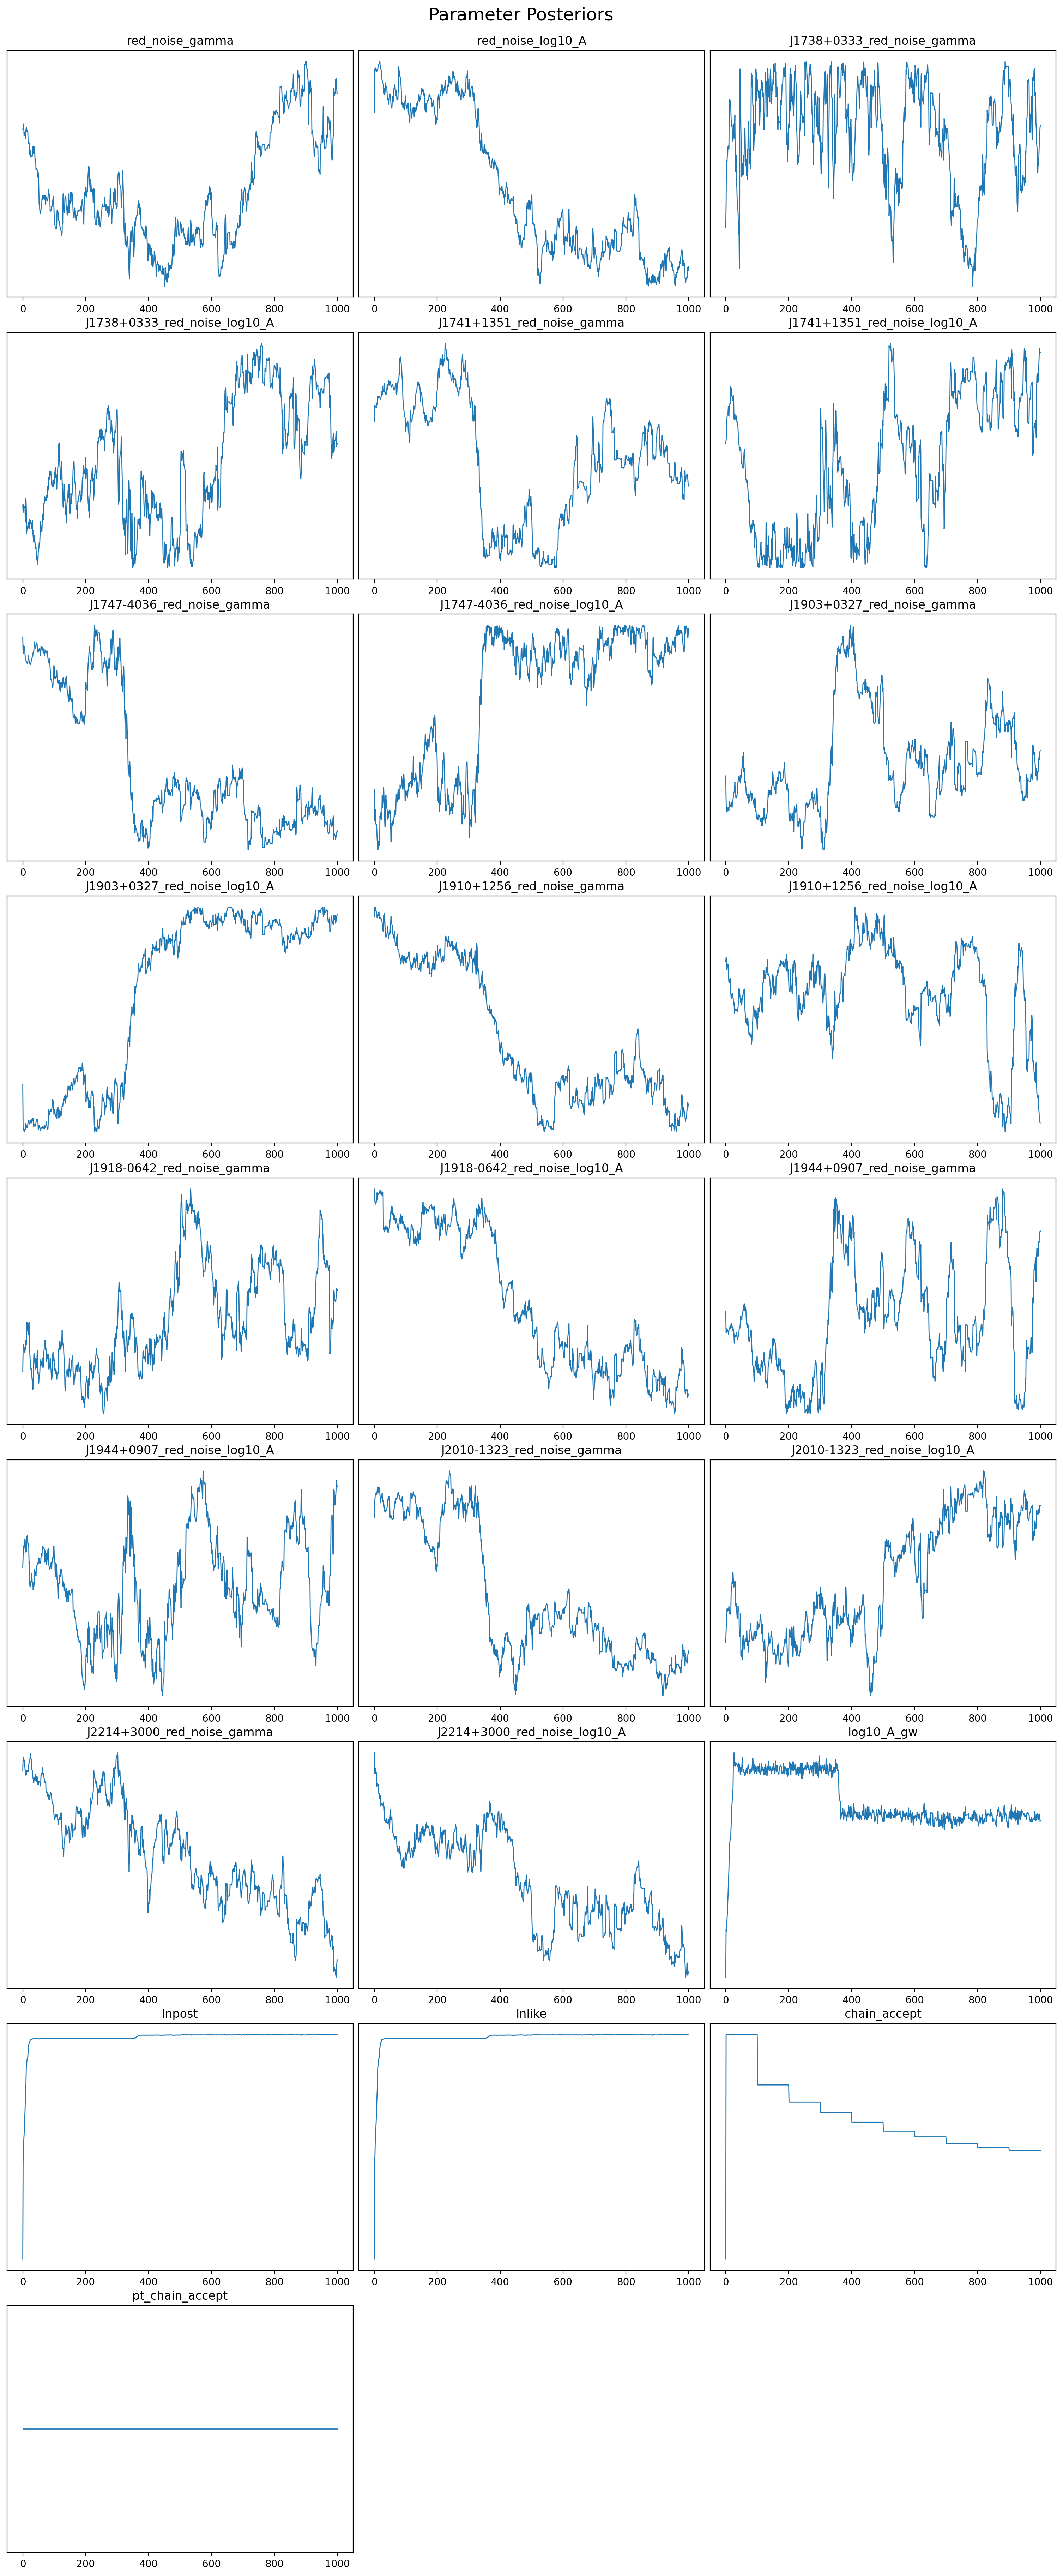

In [14]:
dg.plot_chains(c0, hist=False)

***FAQ:*** I'm often asked what the last four parameters that are printed here are.
- `lnpost` This is the log-posterior (log-likelihood + log-prior) computed for each sample
- `lnlike` This is the log-likelihood computed for each sample
- `chain_accept` This is the cumulative acceptance rate for the MCMC (i.e. number of accepted samples/number of iterations)
- `pt_chain_accept` This is the cumulative acceptance rate for parallel-tempered MCMC. We'll get back to this later, but for now, this should be a straight, flat line.

**Question:** How does this traceplot look to you? Has the sampler explored the parameter space well?

We'll now take a look at the [Gelman-Rubin metric](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic). This is a measure on how well *converged* the chain is. A well-sampled parameter should score a Gelman-Rubin metric < 1.01 (as shown by the dashed black line in the following plot). We use `la_forge.diagnostics.plot_grubin`.

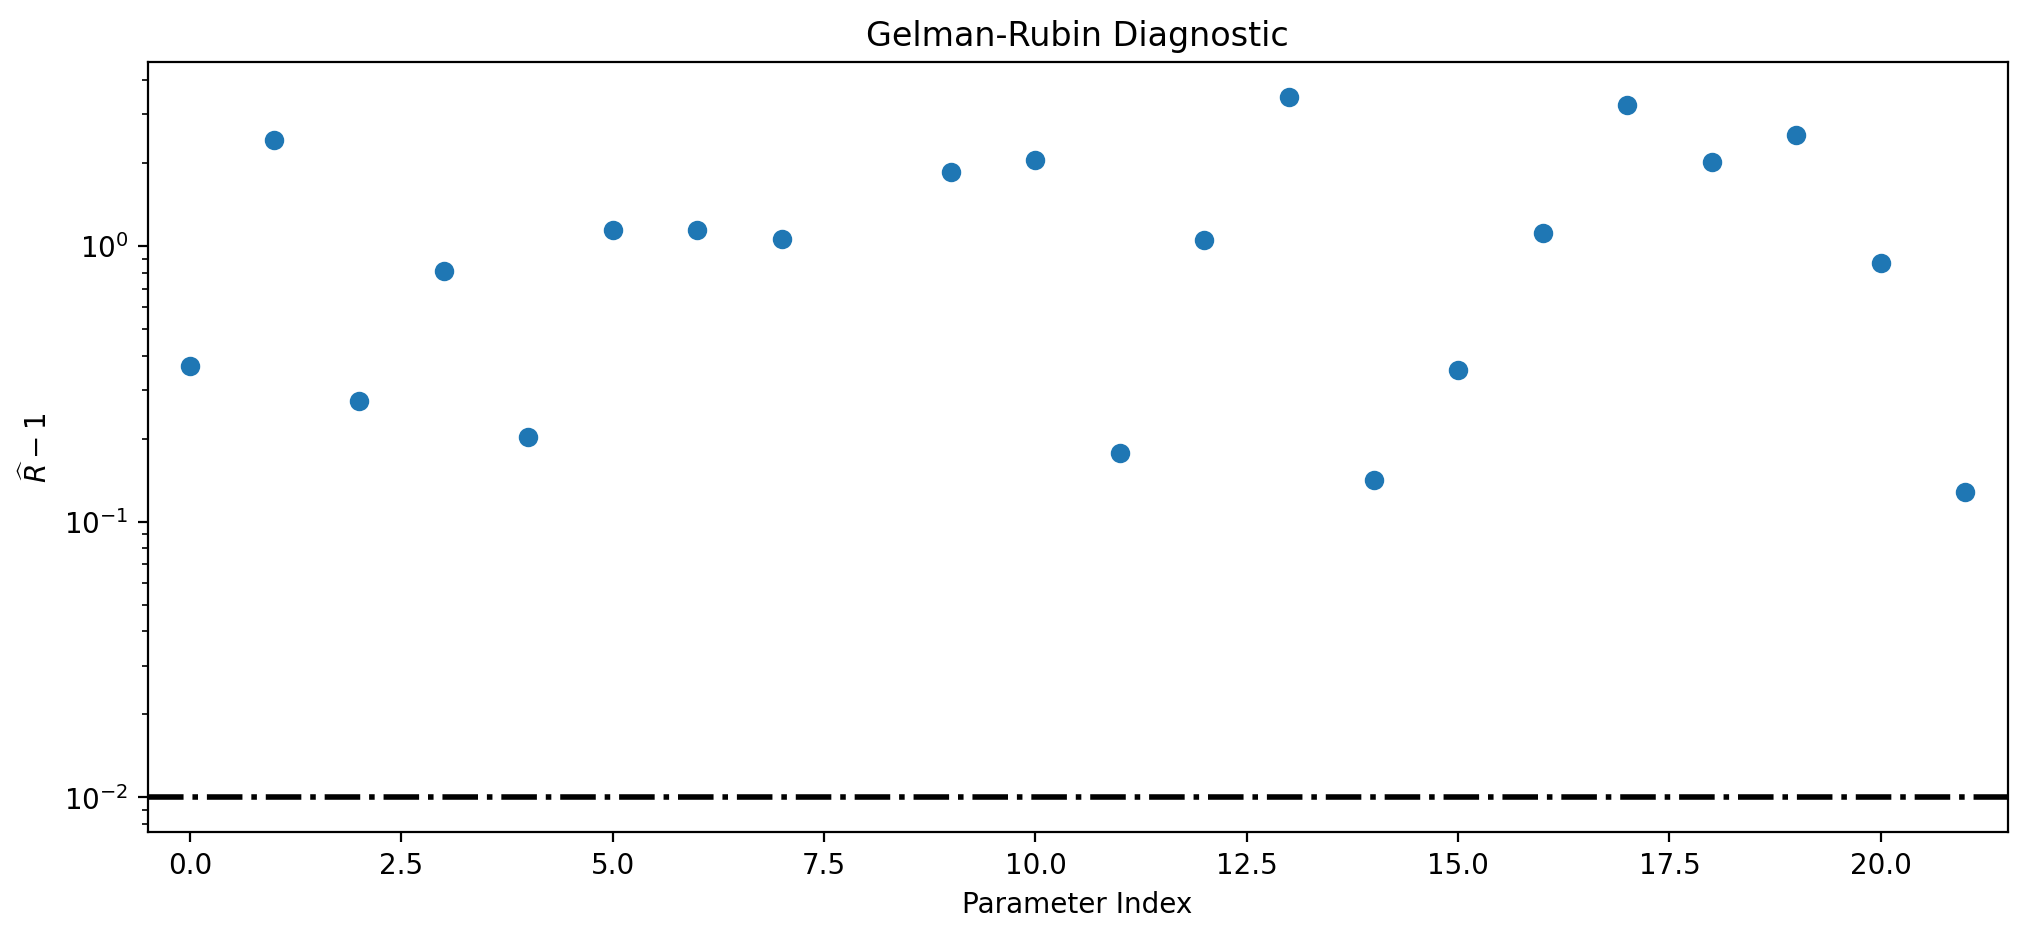

In [15]:
dg.plot_grubin(c0)

**Question:** What does this tell you about your analysis? Have your thoughts about your analysis changed?

Finally, we'll compute the auto-correlation length, which tells us how independent each sample is from each other. An MCMC is a Markov Chain where the current point is dependent only on the last accepted sample, hence we should expect an autocorrelation length of 1 for a perfect MCMC. In reality, a well-sampled parameter will have a short autocorrelation length $\mathcal{O}(1)$. We use `emcee.autocorr.integrated_time`.

In [16]:
acl = np.hstack([integrated_time(c0(p), quiet=True) for p in c0.params])

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [90.62204899]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [134.81602378]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [34.24270173]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [105.53909737]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [73.62245601]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caut

In [17]:
print(f'Autocorrelation length: {acl}')

Autocorrelation length: [ 90.62204899 134.81602378  34.24270173 105.53909737  73.62245601
 116.98741541 130.7466195  129.58519702  48.19826187 130.65827835
 130.62166382  76.1258636   98.77405186 134.59492319  58.76574117
  35.46390478 134.69466345 128.76181304 135.51758113 127.11680277
 106.21184646  19.2770603   19.2770603  139.00744333          nan]


**Question:** What does the autocorrelation length tell you about the number of independent samples in your chain. Remember, we only collected 1000 samples!

Finally, let's take a look at the corner plot of the CURN parameters. Remember that this simulation should have a powerlaw GWB with $\log_{10}A_{1\text{yr}^{-1}}=-14.7$ and $\gamma=13/3$, which we'll plot as 'truth lines.'

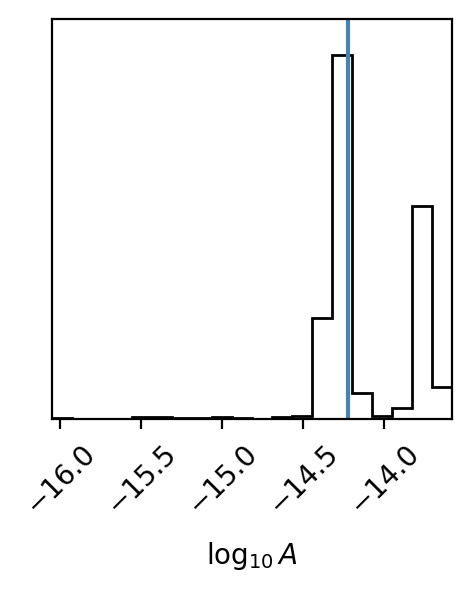

In [18]:
gwb_params = ['log10_A_gw']
labels = [r'$\log_{10}A$']
corner(c0(gwb_params), labels=labels, truths=[np.log10(6e-15)]);

**Question:** What do you think about this corner plot? Has the MCMC recovered the injected values?

### Improving our MCMC

I hope that you agree that our analysis was pretty bad! The traceplot showed that the sampler didn't explore the parameter space at all well; the Gelman-Rubin metric was greater than 1.01 for most, if not all parameters; the autocorrelation length was extremely high given that we only had 1000 samples (note that the parameters with an autocorrelation length >100 means that we had <1 independent point!); and the corner plot shows that the MCMC didn't correctly estimate the GWB parameters!

There are multiple things that we can do to improve our sampling.

#### 'Burning'

It can take a little time for the MCMC to find a good region of parameter space to sample, or in other words, 'burn in.' You should see this in the above plot. For some parameters, you'll see that at the beginning of the MCMC, the traceplot will converge rapidly towards a region it wants to sample (although, that might be hard to see with this example given how poorly the MCMC is sampling).

Therefore, if we want to load in this chain, we need to remove the first few samples. We typically 'burn' the first 25% of samples. This is done for you by default in `la_forge` if you don't define the keyword argument `burn`.

#### Number of samples

If your MCMC satisfies detailed balance, then your MCMC should converge after an *infinite number of points.* Unfortunately, we don't have an infinite amount of time, but we can increase the number of samples that we collect. Increasing `Niter` in `sampler.sampler` will achieve this - just be aware of the amount of time it will take to collect this many samples!

#### Prior draws

Sometimes, your sampler will have selected a great region of parameter space for all but one parameter. But, that one parameter could be so unlikely, your MCMC will reject that point just based on that one bad dimension. Prior draws are useful by randomly selecting a parameter midway through an iteration, and resampling it. If that one point has a higher probability, it will then be used in the interation instead of the originally selected point. This really helps with sampling because every parameter is now less dependent on a difficult-to-sample parameter.

`setup_sampler` applies the prior draws we need for our CURN analyses. However, if you have a model that `setup_sampler` doesn't have a specific prior draw that it can add, this is how you would do it for, let's say, a parameter called `my_parameter`.

```python
from enterprise_extensions.sampler import setup_sampler, JumpProposal
sampler = setup_sampler(pta_curn, outdir=outDir)

def draw_from_my_parameter_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        # draw my_parameter from signal model
        parnames = [par.name for par in self.params]
        pname = ['my_parameter']  # CHANGE THIS LIST FOR YOUR PARAMETERS OF CHOICE

        idx = parnames.index(pname)
        param = self.params[idx]

        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[str(param)]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[self.pmap[str(param)]] = param.sample()


        # forward-backward jump probability
        lqxy = (param.get_logpdf(x[self.pmap[str(param)]]) -
                param.get_logpdf(q[self.pmap[str(param)]]))

        return q, float(lqxy)

JumpProposal.draw_from_my_parameter_prior = draw_from_my_parameter_prior
sampler.addProposalToCycle(sampler.jp.draw_from_my_parameter_prior, 10)
```

#### Jump Proposals

Jump proposals optimise the "jumps" between parameter points in each iteration. If your proposal jump is too small, your sampler won't explore the space very effectively. If your proposal jump is too big, your sampler may overlook narrow, high-likelihood regions. We could run a few trial MCMCs to manually tune our sampler to explore the parameter space effectively (which we can measure using autocorrelation lengths and acceptance rates). Or we can let the sampler do it itself by computing the covariance between parameters (hence the covariance matrix that you supply to your sample) and by learning the history of your entire MCMC.

PTMCMCSampler has three built-in jump proposal schemes, which I won't get into detail here but you can follow the link to [Steve's textbook to learn more](https://arxiv.org/pdf/2105.13270#subsection.6.1.2):
- Adaptive Metroplis (AM)
- Single Component Adaptive Metropolis (SCAM)
- Differential Evolution (DE)

#### Groupings

To help the sampler optimise its jump proposals, it is useful to let the sampler know which parameters are highly covariant to each other. For example, the amplitude and spectral index of the intrinsic red noise for a given pulsar would be covariant to each other, because increasing one would decrease the other. We therefore can supply a list of a list of indices of parameters that we know are covariant to each other, which are then used by the jump proposal schemes.

We can also add our own jump proposals, prior draws, and groupings! Instead of defining our sampler and optimisations from scratch using PTMCMC, we can just simply use `enterprise_extensions.sampler.setup_sampler`.

In [21]:
# we add a list of lists of parameters that we want to group together
from enterprise_extensions.sampler import (get_parameter_groups,
                                           get_psr_groups)
groups = get_parameter_groups(pta_curn)
groups.extend(get_psr_groups(pta_curn))
print(groups)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [20], [15, 14], [11, 10], [1, 0], [3, 2], [9, 8], [7, 6], [13, 12], [5, 4], [17, 16], [19, 18], [14, 15], [10, 11], [0, 1], [2, 3], [8, 9], [6, 7], [12, 13], [4, 5], [16, 17], [18, 19]]


In [20]:
better_sampler = setup_sampler(pta_curn, outdir=outDir, groups=groups, resume=True)
x0 = np.hstack([p.sample() for p in pta_curn.params])
better_sampler.sample(x0, 100_000)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Finished 0.00 percent in 0.005403 s Acceptance rate = 0

/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 35.365201 s Acceptance rate = 0.42765Adding DE jump with weight 20
Finished 51.00 percent in 177.005684 s Acceptance rate = 0.451804

KeyboardInterrupt: 

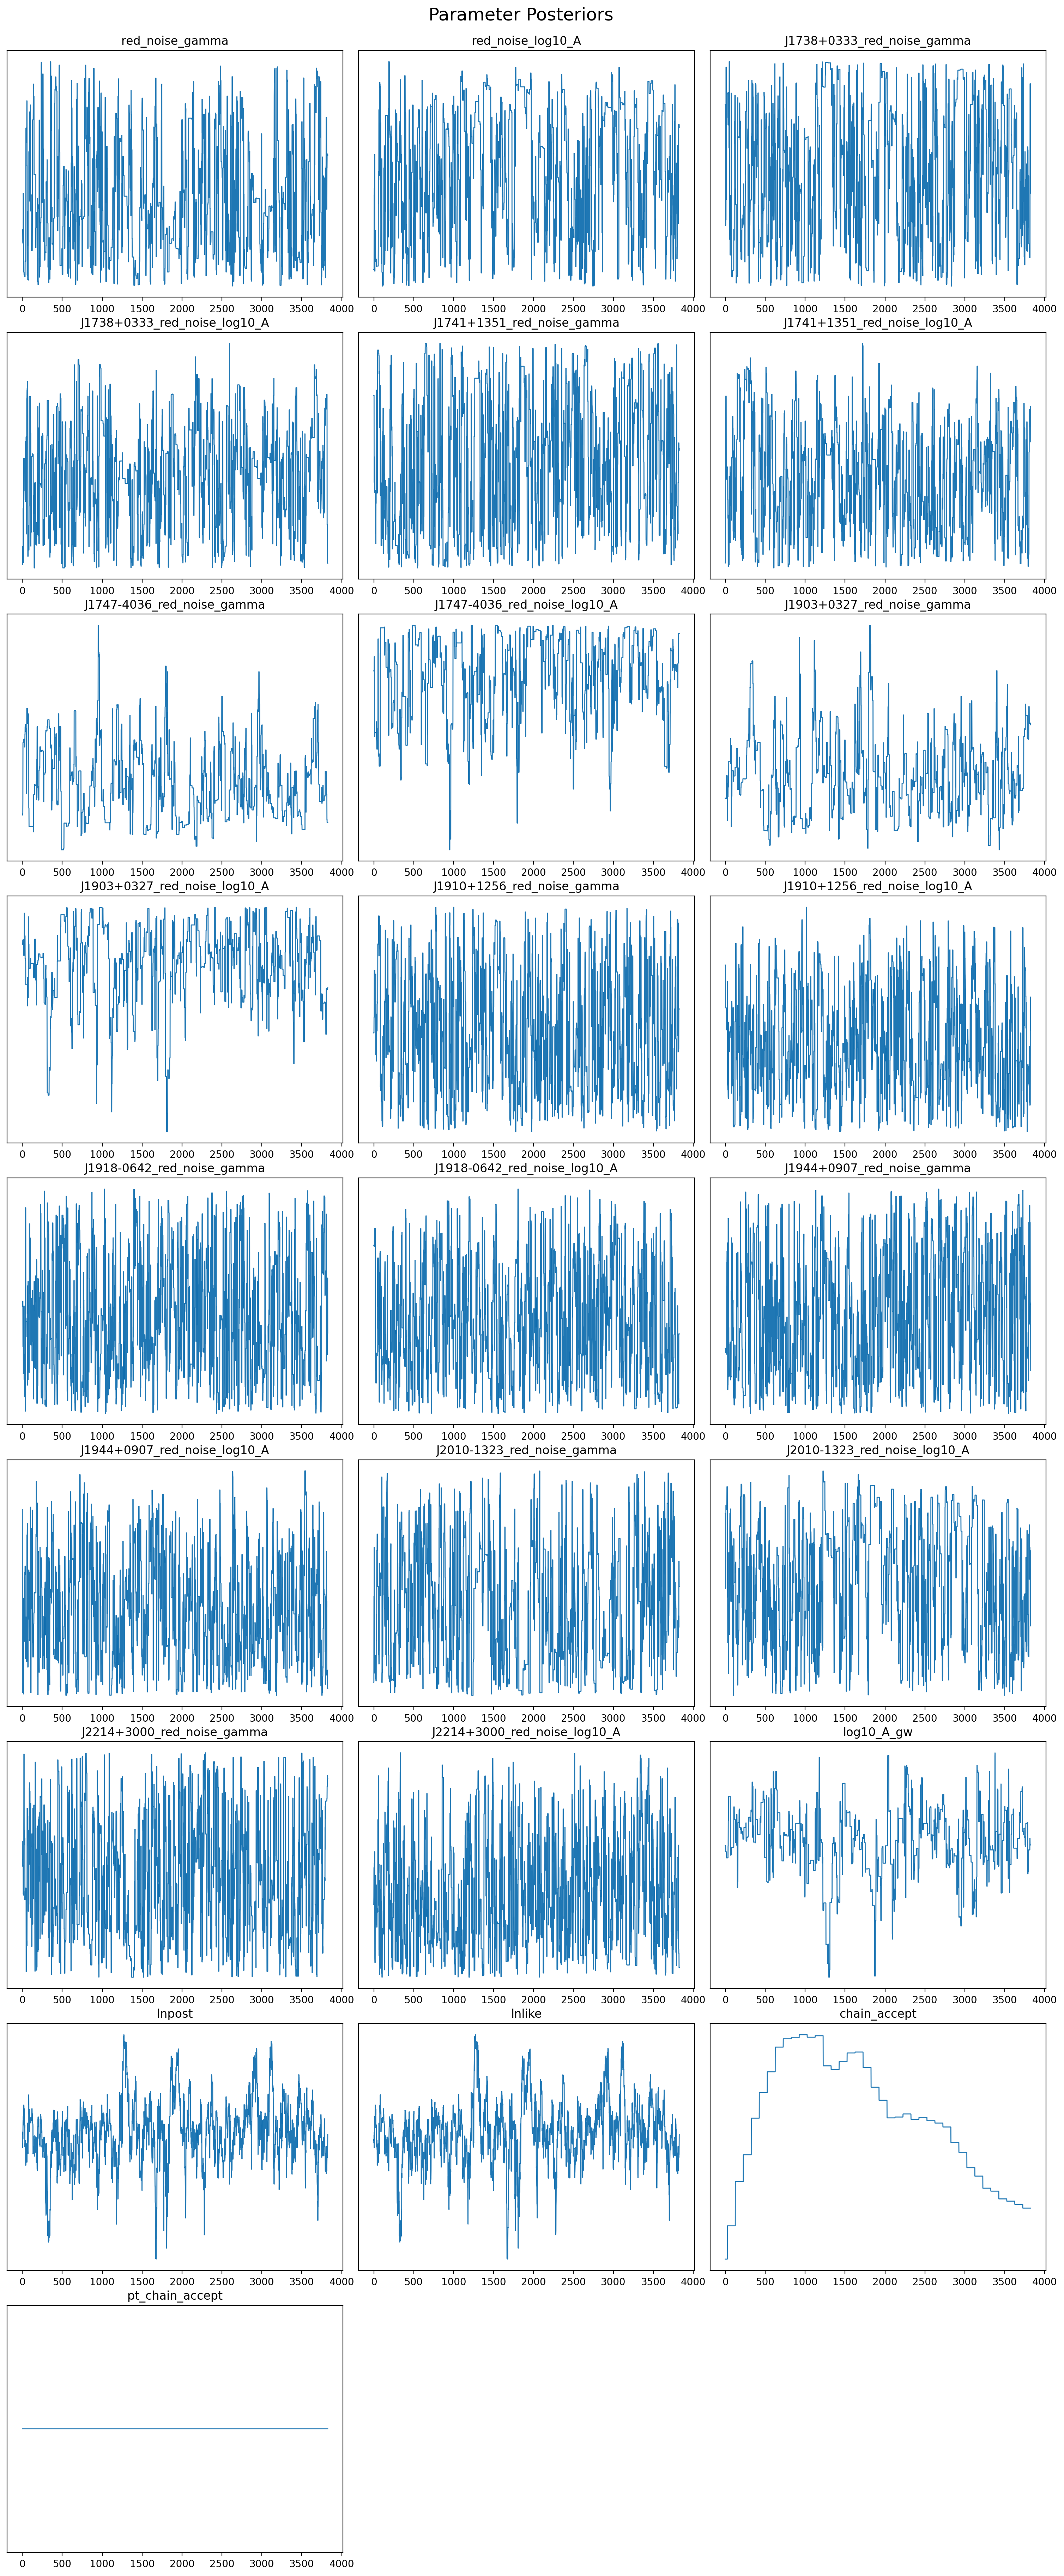

In [22]:
c0 = co.Core(outDir, burn=0.25, params=pta_curn.param_names[:-4])
dg.plot_chains(c0, hist=False)

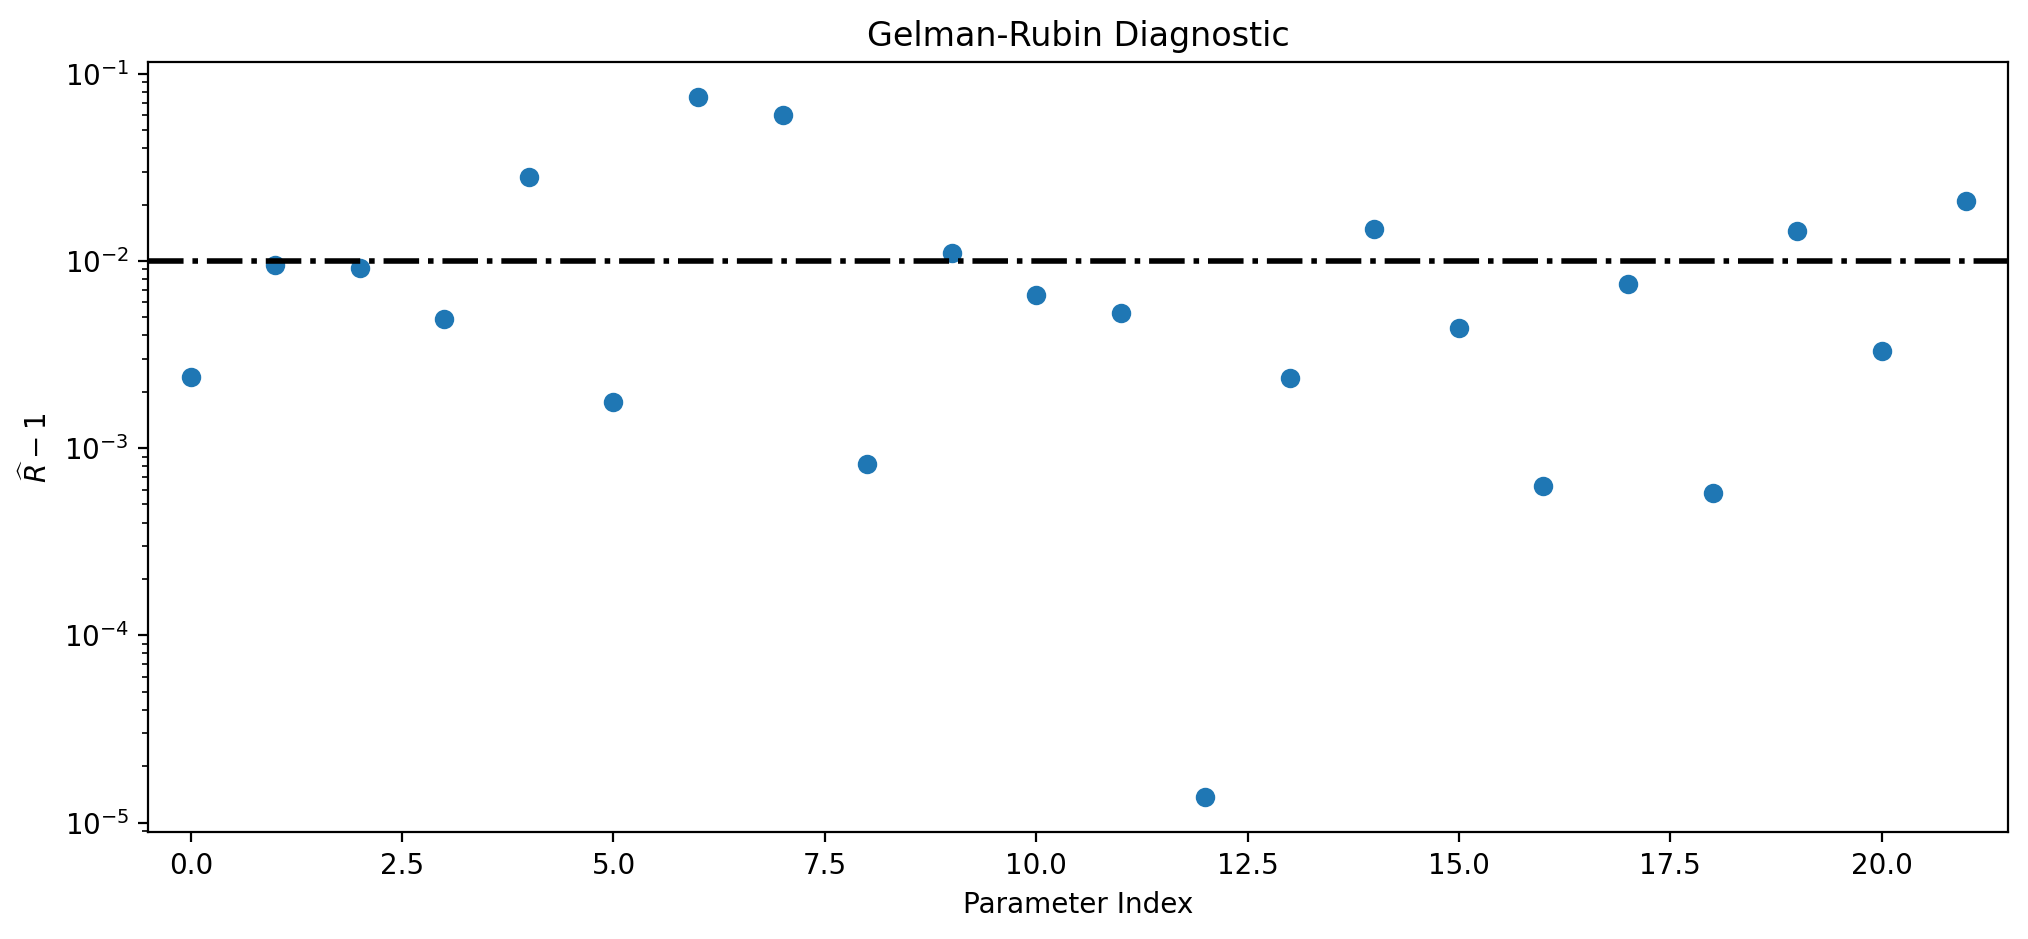

In [23]:
dg.plot_grubin(c0)

In [24]:
acls = np.hstack([integrated_time(c0(p), quiet=True)[0] for p in c0.params])
print(f'Autocorrelation lengths: {acls}')

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 77;
tau: [396.59461247]


Autocorrelation lengths: [ 17.109268    45.82365573  38.57194176  20.77607507  22.28194491
  20.98911562  29.56559962  28.92708528  29.59414984  30.35917966
  14.09812829  13.30084255  14.70238053  13.68517294  18.37690079
  16.96066537  25.18119711  32.14214177  15.45396668  11.00273962
  71.98097576  50.7132512   50.71325048 396.59461247          nan]


/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


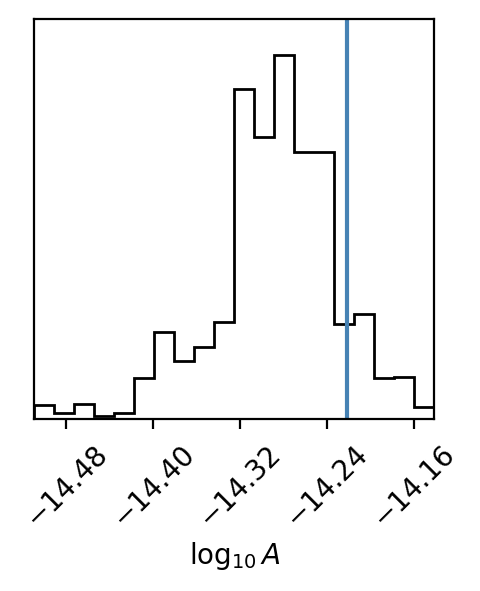

In [25]:
gwb_params = ['log10_A_gw']
labels = [r'$\log_{10}A$']
corner(c0(gwb_params), labels=labels, truths=[np.log10(6e-15)],
       hist_kwargs={'density': True});

Are you happy with your analysis and you'd like to share your chains with your colleagues? You can save your chain as a HDF5 file using `la_forge`.

In [26]:
c0.save(outDir + 'my_first_mcmc.core')

You can then open a chain using `la_forge` too.

In [27]:
c0 = co.Core(corepath=outDir + 'my_first_mcmc.core')

Curious about `la-forge`'s other features and methods? [Here is its documentation!](https://la-forge.readthedocs.io/en/latest/)

### Tips & optimisations
#### MCMC is an art

The biggest tip I've received when running an MCMC is that ***it is not a science, it is an art!*** You could spend forever attempting to finely tune your MCMC to be perfect, but don't let perfection be the **what is this?** Use the above metrics as tools - if one of your parameters is nearly converged but not quite, in particular a nuisance parameter like intrinsic red noise, then your results will still be good! Don't spend forever trying to get the perfect chain. The following tips will also help recover a great chain for you.

#### Acceptance rate
The theoretically perfect acceptance rate is 25%. You should aim to get an acceptance rate of about 20-60%.

#### Resume a chain

Did you not have enough time to run your MCMC? You can 'resume' it from the last saved point! Just set up your sampler with the same output directory and model as before, and state `resume=True` when initialising your sampler.

#### Empirical distributions

When running MCMCs, we run a lot of similar models. In particular, we use a powerlaw model for the intrinsic red noise in each analysis. The recovered posteriors for the red noise amplitude and spectral index won't change much between analyses, even if the GWB model we use is significantly different. Hence, to speed up convergence, we can sample from the posterior of a previous analysis. We can do this by sampling from an *empiricial distribution* of the posterior of a previous analysis.

An empirical distribution is simply a distribution that we have computed empirically, for example with a histogram or a kernel density estimator (KDE).

In [28]:
from enterprise_extensions.empirical_distr import make_empirical_distributions

# make a list of empirical distributions of the parameter posteriors
emp_dists = make_empirical_distributions(pta=pta_curn,
                                         paramlist=pta_curn.param_names[:-1],
                                         params=pta_curn.params[:-1],
                                         chain=c0(pta_curn.param_names[:-1]),
                                         filename=outDir + 'emp_dists.pkl')

In [29]:
print(emp_dists)

[<enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db5c9d0>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db5ea50>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db5ecd0>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2c590>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16d8c6090>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2dcd0>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2ced0>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2c290>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2f750>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2dbd0>, <enterprise_extensions.empirical_distr.EmpiricalDistribution1D object at 0x16db2dd50>, <enterprise_extensions.empirical_distr.Emp

you can then add them to the sampler in `setup_sampler` like so:

```python
better_sampler = setup_sampler(pta_curn, outdir=outDir, groups=groups,
                               empirical_dists=emp_dists)
```

#### Parallel Tempering (PT)

Ah, the PT in PTMCMC! Despite all of the above optimisations, effectively sampling >100 parameters with MCMC is still a very, very difficult task! Fortunately, we have one more optimisation we can use.

Parallel tempering copies the sampler across $N$ CPUs with the Message Passing Interface (MPI). Unlike 'typical' parallel processing, we don't share the work across the CPUs. Instead, we raise the likelihood in each CPU to a power of $1/T_i$, where $T_i$ is the 'temperature' of processor $i$. The root CPU (i.e. 'CPU 0') with have a temperature $T_0=1$, hence $\mathcal{L}_0 = \mathcal{L}^1$. The $n$-th processor with have a temperature $T_n$, hence it evaluates a likelihood of $\mathcal{L}_n = \mathcal{L}^{1/T_n}$. This has the effect of 'smoothing' the likelihood surface as the temperature increases.

A smoother likelihood surface is an easier likelihood surface to explore! Therefore, if you have a really complicated surface with lots of local minima that your sampler could get stuck in, smoothing it out can be really beneficial! The higher temperature chains will explore the surface much easier than the lower-temperature chains, so it will be able to find the higher likelihood regions faster than the low-temperature chains. Every `Tskip` steps, the sampler will communicate between neighbouring chains. If a higher-temperature chain has found a better region to sample, it will swap points with its neighbouring, lower-temperature chain. The lower-temperature chain will now sample the higher-likelihood region.[Here's a link to more information and figures.](https://courses.physics.illinois.edu/phys466/sp2013/projects/2006/team_john_davidsaver/466_gergely_davidsaver/node3.html)

By default, if you were to parallel temper across $N$ CPUs, PTMCMCSampler will choose a maximum temperature $T_N$ such that the parallel-tempering swap acceptance rate (`pt_chain_accept`) across CPUs is 25%, which is the theoretically optimal swapping rate.

Parallel tempering is really difficult with jupyter notebooks. To run parallel tempering, you'll need to run your MCMC from a python script in a terminal. You'd typically run a python script with the following command:

`python your_script.py`

To use parallel tempering, it is trivially easy...

`mpiexec -np 4 python your_script.py`

The `-np 4` flag tells MPI to use 4 CPU cores (hence 4 temperatures). You can change this number depending on the complexity of your model/PTA, and how many CPU cores you have available.

You'll require that MPI to be installed in your environment, and is known to PTMCMCSampler. You can do this with the following command in the terminal:
`conda install -c conda-forge ptmcmcsampler mpi4py`

**For NANOGrav-quality production runs, *USE PARALLEL TEMPERING!***

---
As previously mentioned, the Bayesian evidence $\mathcal{Z}$ for a model given some data is really difficult to compute! But, if we want to compare between two models, computing the ratio of $\mathcal{Z_2}/\mathcal{Z_1}$ gives you the Bayes Factor between models $\mathcal{M}_1$ and $\mathcal{M}_2$, which can tell us which models fit the data better.

Here are ways to estimate the Bayes Factors between two different models.

---
## Technique 2: Savage-Dickey Density Ratio (SDDR)

*Uses:* Model selection between two models. One model must have one parameter in addition to the parameters in the other model.

The SDDR is a very simple technique to compute Bayes Factors between two models, but only if one model has one additional parameter compared to the other model. [See Kyle's tutorial yesterday.](https://github.com/VIPER-Research-Group/gw-school-2024-materials/blob/main/Day_2/Tutorials/Numerical_FreqBayes.ipynb)

For example, would you like to check if there's some support for an uncorrelated GWB over an intrinsic red noise-only model? We can do this by running a fixed-$\gamma$ powerlaw CURN analysis. Both models will have the same intrinsic red noise models for each pulsar, but the second model will have an additional parameter that fits the amplitude of the CURN signal, $\log_{10}A$. We use information on the posterior of $\log_{10}A$ to compute the SDDR, which is the Bayes Factor in favour of a CURN process over a GWB.

Conveniently, you've just ran a $\gamma=13/3$-powerlaw CURN analysis, where the prior on $\log_{10}A$ is uniform between -18 and -12... So what is the Bayes Factor between fixed-$\gamma$ CURN and intrinsic red noise-only model?

In [30]:
from enterprise_extensions.model_utils import bayes_fac
samples = co.Core(corepath='./results/my_first_pta_mcmc/my_first_mcmc.core')('log10_A_gw')

sddr, sddr_err = bayes_fac(samples, logAmin=-18, logAmax=-12)

/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/enterprise_extensions/model_utils.py:196: RuntimeWarning: divide by zero encountered in scalar divide
  bf.append(prior/post)
/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, d

In [31]:
print(f'Bayes Factor = {sddr:.2f} +/- {sddr_err:.2f}')

Bayes Factor = nan +/- nan


**Question:** Huh, we get NaNs... Why do you think this is?

## Technique 3: Product-space sampling (a.k.a HyperModel)

The HyperModel framework is a really useful method to estimate a Bayes Factor between two models with the same parameters. For example, it allows us to compute the Bayes Factor between a CURN model and a HD model. The idea is simple: we add a switch called `nmodel` that has a uniform probability to select between our two models. The switch is sampled by our MCMC! The model with the higher probability will be sampled more often.

The Bayes Factor between the two models is very simple. It is just the ratio between the number of samples collected for model 1 and the number of samples collected for model 2!

$$\text{BF}_{12} = \frac{N_{\text{samples}, 1}}{N_{\text{samples}, 2}}$$

To ensure that you recover an accurate Bayes Factor, you may have to *weight* your models. A model that is significantly more probable than the other will not, for lack of better words, 'hog the sampler.' (Please let me know if this Britishism translates!) This has the effect of increasing the probability of the more unlikely model, allowing the HyperModel sampler to better sample both models. *Don't forget to correct the weighting when computing your Bayes Factor!*

Note that it may take several attempts for you to find the correct weighting. You'll have to run the MCMC for a bit, check it, tune it, run it, and so on, until both models are being sampled well!

In [32]:
outdir = './results/my_first_hm/'
pta_models = {0: pta_curn, 1: pta_hd}
log_weights = [5, 1]

hm = HyperModel(pta_models, log_weights=log_weights)
hm_sampler = hm.setup_sampler(outdir=outdir, groups=groups,
                              empirical_distr=emp_dists)

x0 = hm.initial_sample()
hm_sampler.sample(x0, 10000)

Extending empirical distributions to priors...

Adding empirical proposals...

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...

Finished 0.00 percent in 0.010282 s Acceptance rate = 0

/Users/lambwg/miniconda3/envs/viper-gw-school/lib/python3.11/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 40.00 percent in 32.375783 s Acceptance rate = 0.43325

KeyboardInterrupt: 

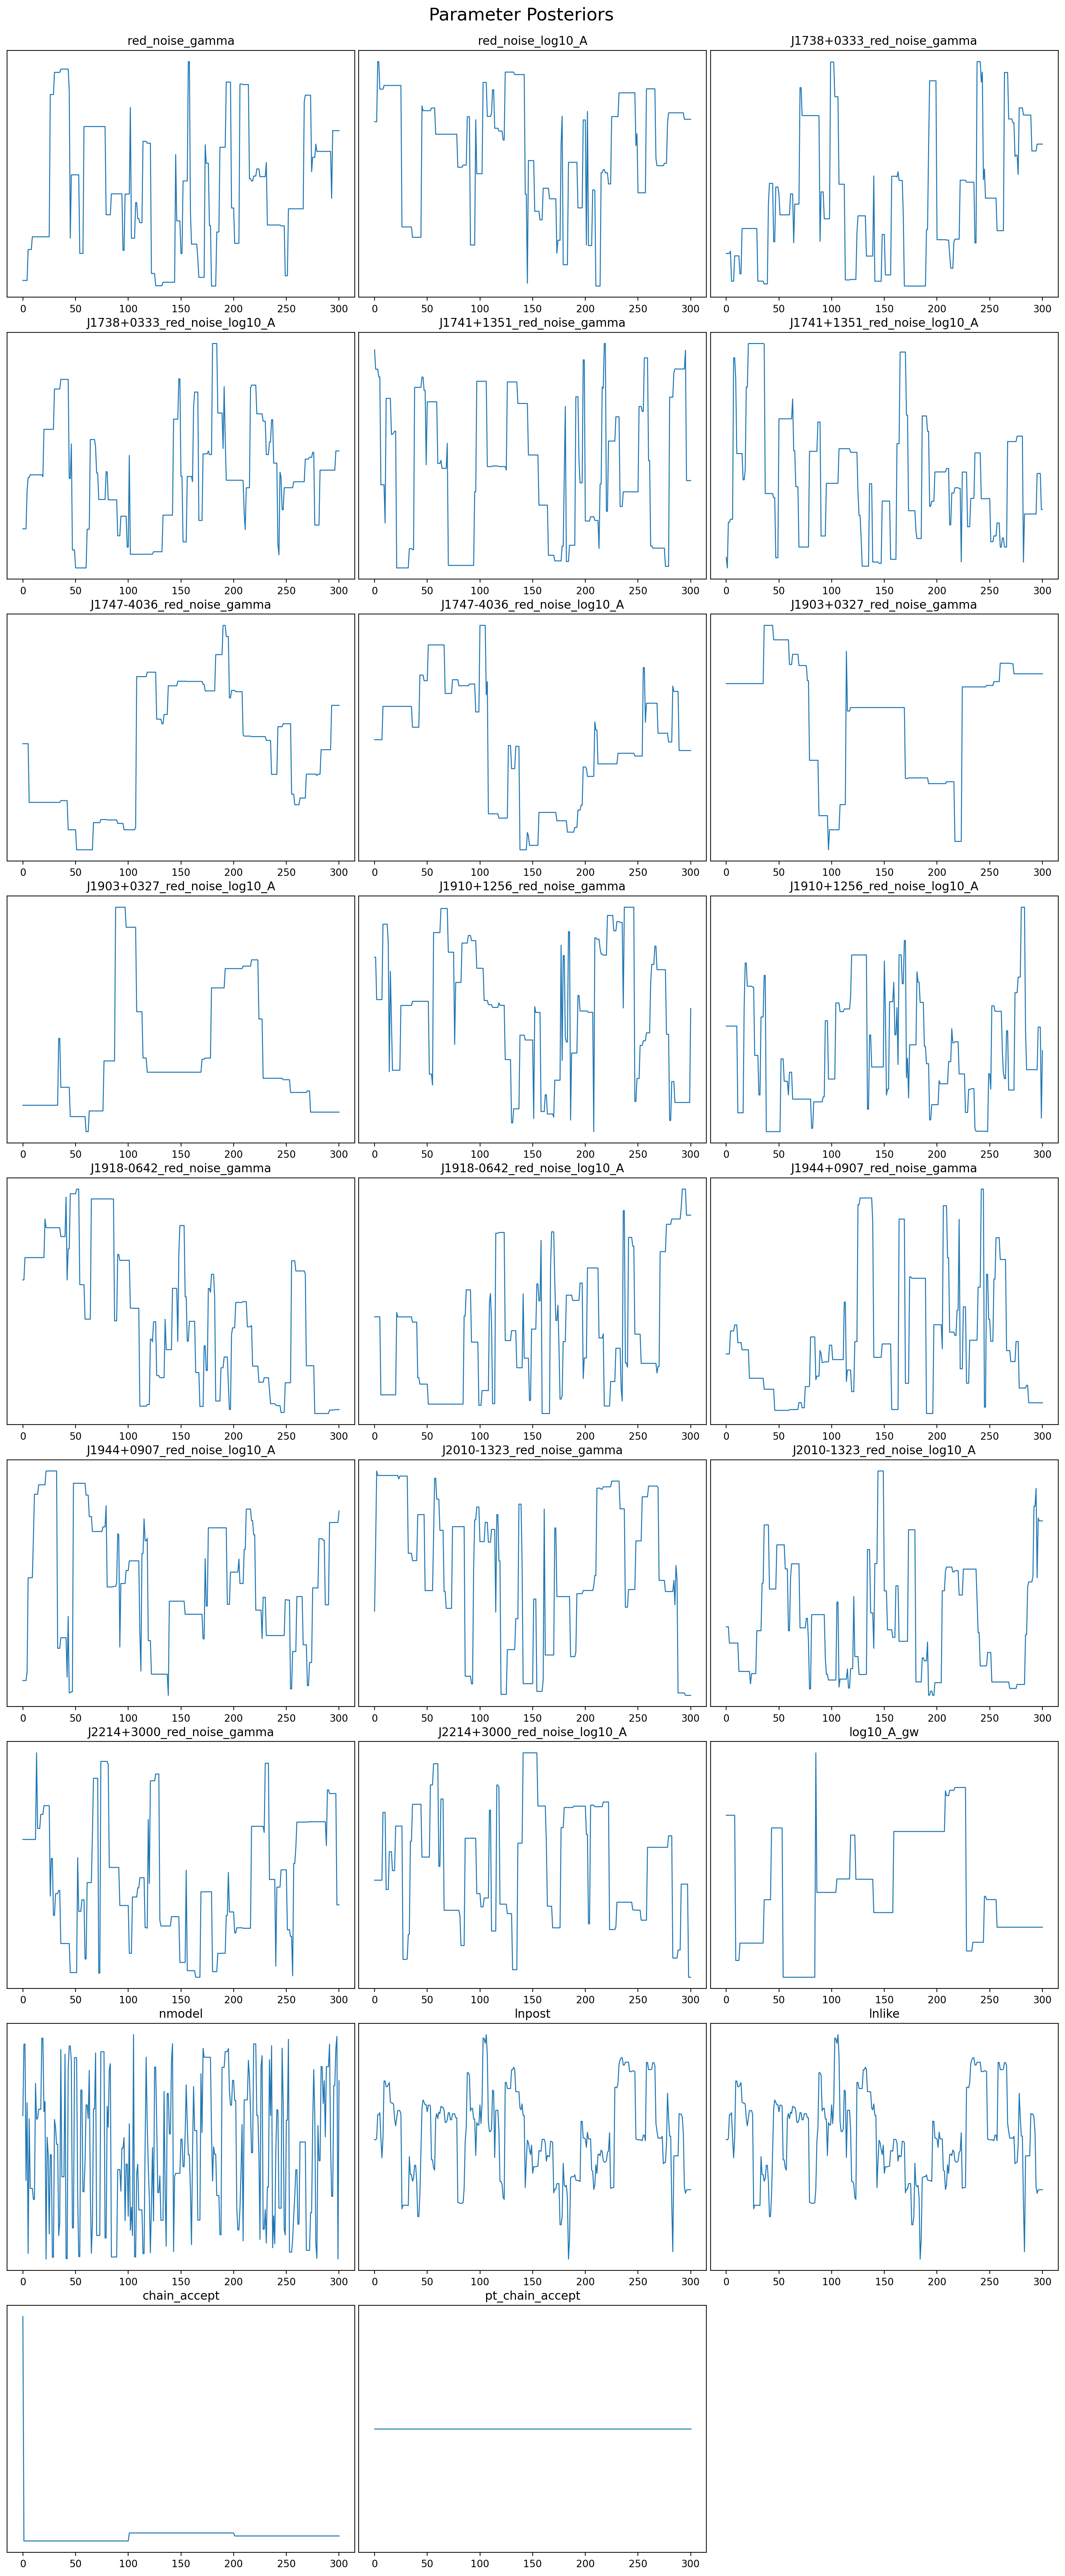

In [33]:
# load the chain
hm_core = co.Core(outdir)

# plot the chains
dg.plot_chains(hm_core, hist=False)

We'll skip over the other metrics we us to check the analysis... How did `nmodel` sample?

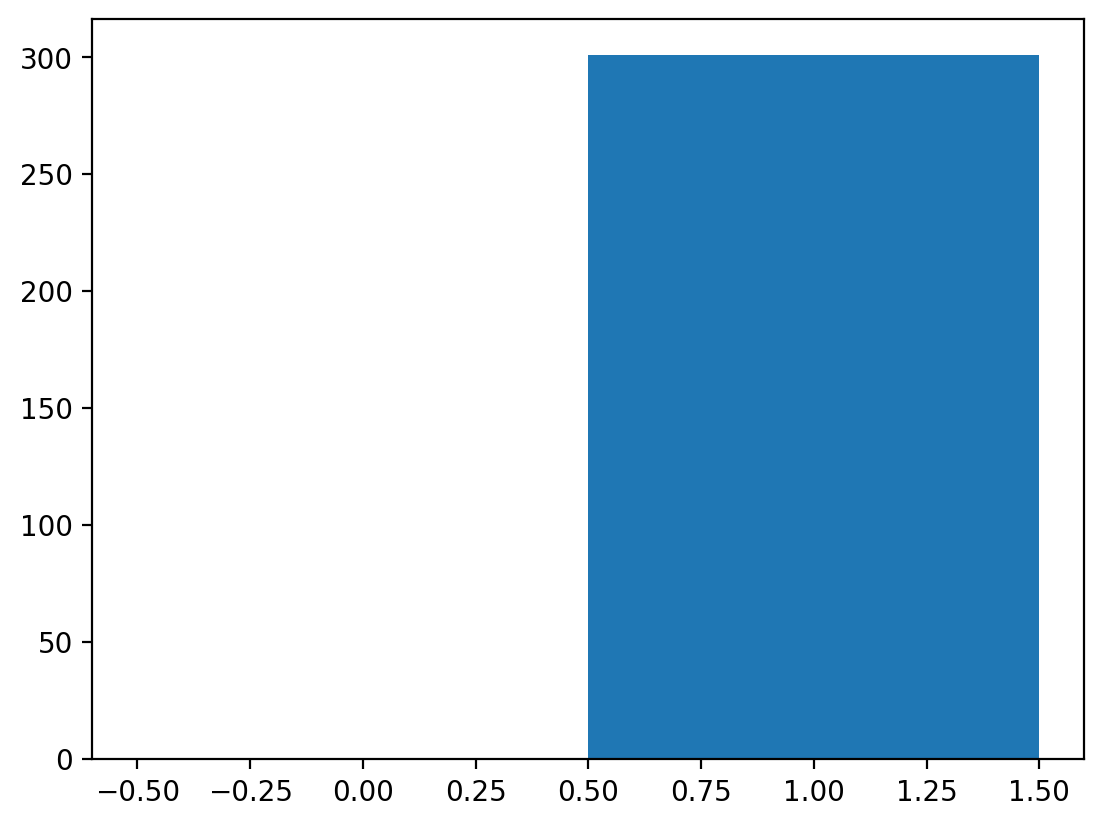

In [34]:
plt.hist(hm_core('nmodel'), bins=[-0.5, 0.5, 1.5]);

In [35]:
# let's compute the Bayes Factor
nmodel = hm_core('nmodel')
bf = np.sum(nmodel > 0.5) / np.sum(nmodel < 0.5) / np.exp(log_weights[1] - log_weights[0])

/var/folders/n5/tlyhfd1j5s7gm9fxj02byc0c0000gn/T/ipykernel_14744/1680723103.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  bf = np.sum(nmodel > 0.5) / np.sum(nmodel < 0.5) / np.exp(log_weights[1] - log_weights[0])


In [36]:
print(f'Bayes Factor HD vs CURN: {bf:.2f}')

Bayes Factor HD vs CURN: inf


**Important note:** as of July 7th 2024, there is an issue with HyperModel where using parallel tempering with weighted models bias the Bayes Factor. We don't know why.

Do not use parallel tempering if you're weighting your models! I recommend to first run the simplest model by itself with parallel tempering, and create empirical distributions of each parameter. Then, apply the HyperModel framework with these empirical distributions to reach convergence faster.

---

## Technique 4: Nested sampling

Nested sampling is a method that actually lets you estimate $\mathcal{Z}$ for a model! But be warned... it is extemely difficult.

Remember that $\mathcal{Z} = \int \mathcal{L}(\vec{\theta}|\vec{d}, \mathcal{M})p(\vec{\theta}|\mathcal{M}) \mathrm{d}\vec{\theta}$ - we're essentially computing an integration! To do this, we must compute the likelihood accurately across many points in our parameter space, and especially in the highest-likelihood regions.

The nested sampler samples from a unit hypercube with the same number of dimensions as the number of parameters in our model. It starts by selecting $N$ number of points from the hypercube. Those points are then transformed into our parameter space, which we can do using inverse transform sampling or by computing the point percentile function. The likelihood of all of these points is the computed and ranked from least likely to most likely.

The sampler 'kills' the least likely points, and finds a new point with a higher likelihood than this killed point. The likelihood of the killed point is then add to the integrand. The sampler will continue to run until the integral reaches a numerical tolerance. Effectively, we're summing up the likelihood surface.

**Warning:** Nested sampling is great when you have $\mathcal{O}(1)$ parameters. But as you increase the number of parameters, the slower it gets. While different nested samplers utilise different techniques to optimise them, it is not usually feasable to use nested sampling for a problem with $>50$ parameters. Also, it is normal for nested sampling to be really slow at the beginning and at the very end.

Some nested samplers include `dynesty` and `ultranest`. Let's use `dynesty`. In the command line,

```bash
pip install dynesty
```

In [37]:
def hypercube(u):
    """
    This function transforms a unit hypercube to a fixed-gamma CURN prior.
    This is a hack. Do not use this in production. You can find a better
    implementation in my (William G. Lamb's) fork of enterprise
    (https://github.com/astrolamb/enterprise/blob/e6f1e4ce12764c91dd18b4e22e1e565784e2ecad/enterprise/signals/signal_base.py#L685)
    """

    x0 = np.zeros_like(u)
    x0[:-1:2] = u[:-1:2] * 7
    x0[1::2] = u[1::2] * 6 - 18
    x0[-1] = u[-1] * 6 - 18

    return x0

In [38]:
import dynesty

sampler = dynesty.NestedSampler(pta_curn.get_lnlikelihood,
                                hypercube, len(x0))
sampler.run_nested()
sresults = sampler.results

4110it [05:51, 11.68it/s, +500 | bound: 14 | nc: 1 | ncall: 341805 | eff(%):  1.351 | loglstar:   -inf < 37662.744 <    inf | logz: 37655.376 +/-  0.112 | dlogz:  0.001 >  0.509]


The log Bayesian evidence `logz` and its uncertainty `logzerr` is a key in the `sresults` dictionary. To compute a Bayes Factor, rerun the nested sampler with a different model and find the difference between logZs.

In [39]:
print(f'Bayesian evidence for fixed-gamma CURN model: log(Z) = {sresults.logz[-1]:.2f} +/- {sresults.logzerr[-1]:.2f}')

Bayesian evidence for fixed-gamma CURN model: log(Z) = 37655.38 +/- 0.21


In [40]:
import dynesty

sampler_hd = dynesty.NestedSampler(pta_hd.get_lnlikelihood,
                                   hypercube, len(x0))
sampler_hd.run_nested()
sresults_hd = sampler_hd.results

4197it [14:08,  4.94it/s, +500 | bound: 14 | nc: 1 | ncall: 350936 | eff(%):  1.340 | loglstar:   -inf < 37672.257 <    inf | logz: 37664.711 +/-  0.115 | dlogz:  0.001 >  0.509]


In [41]:
print(f'Bayesian evidence for fixed-gamma CURN model: log(Z) = {sresults_hd.logz[-1]:.2f} +/- {sresults_hd.logzerr[-1]:.2f}')

Bayesian evidence for fixed-gamma CURN model: log(Z) = 37664.71 +/- 0.21


In [42]:
logBF = sresults_hd.logz[-1] - sresults.logz[-1]
print(f'{logBF:.2f}')

9.34


## Other techniques

There are so so many more ways that you can analyse PTA data with Bayesian methods! We give pros and cons

- [ceffyl](https://github.com/astrolamb/ceffyl)
    - ceffyl allows users to fit GWB models to a compressed representation of PTA data for parameter estimation and model selection. You don't need to fit the intrinsic red noise! It is 100-10,000x faster than the enterprise, therefore it can also be used with nested sampling for extremely fast model selection.

    If you're interested in using this method, ask me!
- [PTArcade](https://andrea-mitridate.github.io/PTArcade/)
    - PTArcade was developed by NANOGrav's 'New Physics' community to make it easier for them to parameter estimate their GWB models. It can be used in `ceffyl` or `enterprise` mode.

    Ask me (or David Wright during the hack week!) if you're interested in using PTArcade!

- [QuickCW](https://quickcw.readthedocs.io/en/latest/)
    - This is a software package to quickly search and characterise gravitational waves from individual supermassive black hole binaries ('continuous waves') in PTA data.

    Ask Polina Petrov for advice on using this code!

- Gibbs sampler
    - Gibbs sampling is a highly efficient Monte Carlo sampler, if you have an analytical form for your distribution!

    This is currently being developed by Nima Laal, Steve Taylor, and myself. We plan to work on it during the hack week.

- [etudes](https://github.com/gabefreedman/etudes/tree/main)
    - Do you have a target distribution that is extremely difficult to sample efficiently? The [Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) (HMC) is your friend, if you have a Hamiltonian form for your problem!

    `etudes` is developed by Milwaukee NANOGraver Gabe Freedman.

- Thermodynamic integration
    - NGL, I don't really know enough about this one to explain it. I just know it's difficult... [Here's some more information.](https://en.wikipedia.org/wiki/Thermodynamic_integration)

...and there so many other methods and techniques being developed and introduced all of the time. We haven't been able to mention ensemble walkers, reversable jump MCMC, and more!

Do you have an idea? Or have you found a cool method that is not being used yet in PTA science? Let's try it out in the hack week!

## Exercises

Here are some problems for you try to test out your new skills!

**Problem 1:**

Sample a model with 5-frequency powerlaw intrinsic red noise and 5-frequency powerlaw fixed-$\gamma$ HD-correlated GWB with all 45 pulsars. Apply groupings. Run post processing on this analysis (and plot the corner plot), and create empirical distributions from the posterior.

*Bonus:* Run this analysis with parallel tempering. Take a look at the example script I have prepared for you, `pta_hd_mcmc.py`.

In [ ]:
import os, pickle
import numpy as np
from enterprise.signals import gp_priors, parameter, gp_signals, signal_base, white_signals
from enterprise_extensions.model_orfs import hd_orf
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions.sampler import setup_sampler
from enterprise_extensions.sampler import (get_parameter_groups,
                                           get_psr_groups)
import la_forge.core as co





selected_psrs = psrs
#creating timing model from TMM
tm = gp_signals.MarginalizingTimingModel()

#creating white noise model ONLY using gaussian efac
#diagonal matrix containing all toaerrs
efac = parameter.Constant(1.0)
wn = white_signals.MeasurementNoise(efac=efac)


# intrinsic red noise, sampling randomly from these sources
log10_A_rn = parameter.Uniform(-18, -12)
gamma_rn = parameter.Uniform(0, 7)
#computes power spectral density of red noise
rn_psd = gp_priors.powerlaw(log10_A=log10_A_rn, gamma=gamma_rn)    #can use different models such as free spectra  too
#computes red noise covariance matrix from red noise power spectral density
rn = gp_signals.FourierBasisGP(rn_psd, Tspan=Tspan, components=5)

# gwb
log10_A_gw = parameter.Uniform(-18, -12)('log10_A_gw')
#gamma_gw = parameter.Uniform(0, 7)('gamma_gw')
gamma_gw = parameter.Constant(13/3)('gamma_gw')    
gw_psd = gp_priors.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
hd = gp_signals.FourierBasisCommonGP(gw_psd, hd_orf(), Tspan=Tspan,
                                     components=5, name='gw_hd')  # HD, common red noise model using hd_orf()

#model current run
model_curn = tm + wn + rn + hd
#pta model current run
pta_curn = signal_base.PTA([model_curn(p) for p in psrs])
# we add a list of lists of parameters that we want to group together
groups = get_parameter_groups(pta_curn)
groups.extend(get_psr_groups(pta_curn))


outdir = './results/30fPLirn_10fPLhd_gamma4p33_20yrsim/'

# do you have any empirical distributions? Load them and include them!

better_sampler = setup_sampler(pta_curn, outdir=outdir, groups=groups,
                               empirical_distr=None)

x0 = np.hstack([p.sample() for p in pta_curn.params])
better_sampler.sample(x0, 5e6)

# save the chain as a la_forge core object
c0 = co.Core(outdir)
c0.save(outdir + '30fPLirn_10fPLcrn_gamma4p33_20yrsim.core')

**Problem 2:**

What is the Bayes Factor between CURN and HD-correlated models with all 45 pulsars? Use hypermodel

**Problem 3:**

On the 10 pulsar models, compute the Bayes Factor between CURN and HD models with nested sampling